### Project 1: 使用Keras进行交通信号识别
#### 此项目基于本人参加的兰州大学和谷歌组织的培训，感谢兰大和谷歌
##### 苏康 2018-8-16

### 整个项目可分为以下4个步骤
1. 数据采集
2. 预处理数据集(主要为图像数据),使之能够feed到神经网络
3. 使用keras构建卷积神经网络模型
4. 查看模型在测试集上的准确率

### 1.数据采集

In [1]:
###required libraries
import os
import skimage
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout,Convolution2D,MaxPooling2D
from keras.optimizers import RMSprop,SGD
from skimage import color,transform,data

Using TensorFlow backend.


In [3]:
###让图像镶嵌在notebook内
%matplotlib inline 

### 训练集

Belgian Traffic Sign Dataset. 
下载链接： http://btsd.ethz.ch/shareddata/ 
只需要下载：**BelgiumTS for Classification (cropped images)**":	
* BelgiumTSC_Training (171.3MBytes)
* BelgiumTSC_Testing (76.5MBytes)

下载完后，目录应该如下:

```
data/Training/
data/Testing/
```

每个目录下包含 62 个子目录（从 00000 到 00062）. 文件名即为Label

### 如果下载不了，我可提供

### 下载完，可见图片格式为不常见的ppm格式文件，这里需要skimage工具包来读取图片

In [4]:
os.getcwd()###这个对windows和 Linux 都适用
##cwd (means current working direction)

'E:\\Python\\workspace'

In [5]:
path='./traffic_sign_classifer/traffic_sign_classifer/data/Training'
###or path=os.getcwd()+'/traffic_sign_classifer/traffic_sign_classifer/data/Training'
##注意是'/'  不是'\'
#os.listdir(path)

### 尝试运行 os.listdir(path)

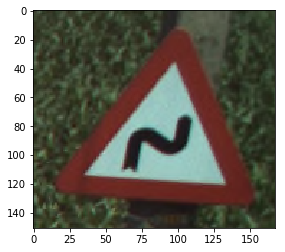

In [6]:
test_img=path+'/00006/00215_00000.ppm'
I=skimage.data.imread(test_img)
plt.imshow(I)

In [7]:
print(os.path.isdir(path+'/10001'),os.path.isdir(path+'/00001'))

False True


In [8]:
test_img.endswith('.ppm')

True

### Q1:程序设计

def load_data(data_dir):

    return images,labels
    
#### 输入变量：给定文件地址 data_dir（为Training 或者Testing）,返回images, labels
把所有.ppm图像数据读入到一个列表image里面，并且把图像文件上一层目录名称(如0006)保存到label内

In [9]:
def load_data(data_dir):
    images=[]
    labels=[]
    img_subdirs=[d for d in os.listdir(data_dir) if os.path.isdir(data_dir+'/'+d)]
    for folders in img_subdirs:
        for items in os.listdir(data_dir+'/'+folders):
            if items.endswith('.ppm'):
                images.append(skimage.data.imread(data_dir+'/'+folders+'/'+items))
                labels.append(int(folders))
    return images,labels

##################
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [10]:
a=[1,2,3]
l=a.append([4])
print(l)

None


In [11]:
imgs,labs= load_data(path)

In [12]:
print("数据集一共有{0}个标签，共有{1}张图像。".format(len(set(labs)),len(imgs)))

数据集一共有62个标签，共有4575张图像。


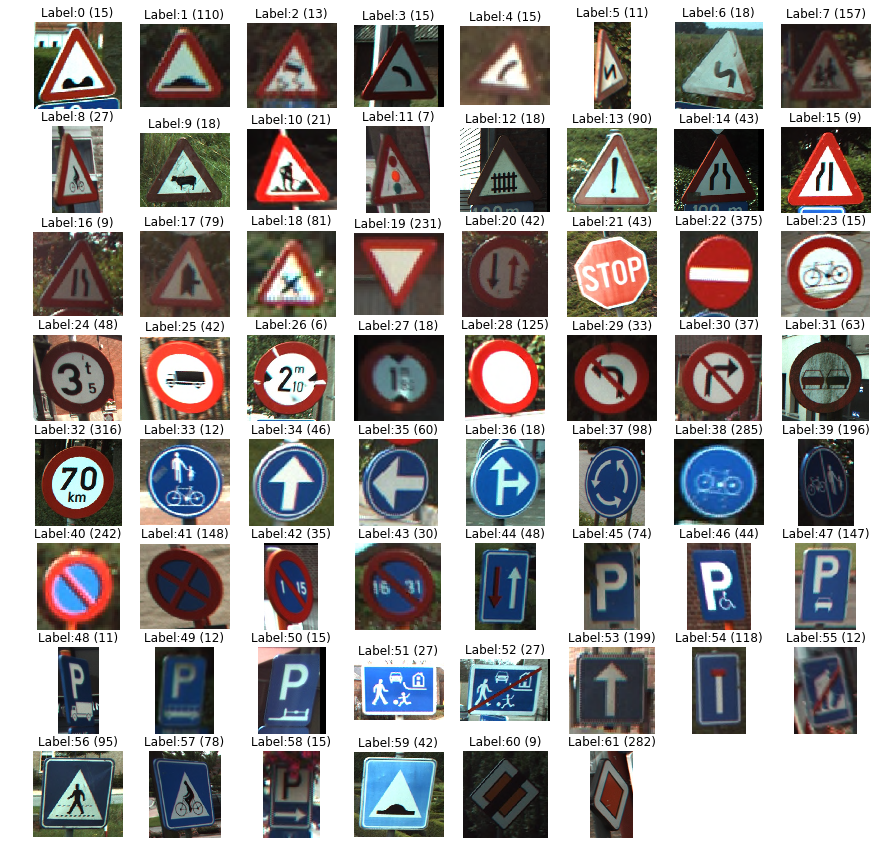

In [13]:
####显示每个标签的第一张图像，并且累积每个标签内部图像的个数
def display_imgs_and_labels(imgs,labs):
    plt.figure(figsize=(15,15))
    i=1
    for j in range(len(set(labs))):
        img=imgs[labs.index(j)]
        plt.subplot(8,8,i)
        plt.axis('off')
        plt.title("Label:{0} ({1})".format(j,labs.count(j)))
        plt.imshow(img)
        i+=1
    plt.show()
    
display_imgs_and_labels(imgs,labs)  

### 2.预处理数据集(主要为图像数据),使之能够feed到神经网络

e:\python\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
e:\python\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


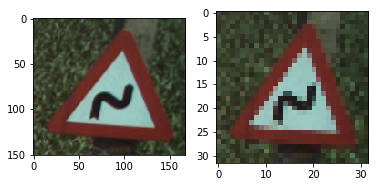

In [14]:
###由输出可见每个图像的尺寸不一致，神经网络往往需要固定大小的输入，这里需要对图像进行裁剪
#test_img=path+'/00006/00215_00000.ppm'
#I=skimage.data.imread(test_img)
plt.subplot(1,2,1)
plt.imshow(I)
I2=skimage.transform.resize(I,(32,32))
plt.subplot(1,2,2)
plt.imshow(I2)

### 通过调用skimage.transform.resize可以把图像裁剪成固定大小

In [15]:
###列表推导式完成批量裁剪
images32=[(skimage.transform.resize(item,(32,32))) for item in imgs]

e:\python\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
e:\python\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


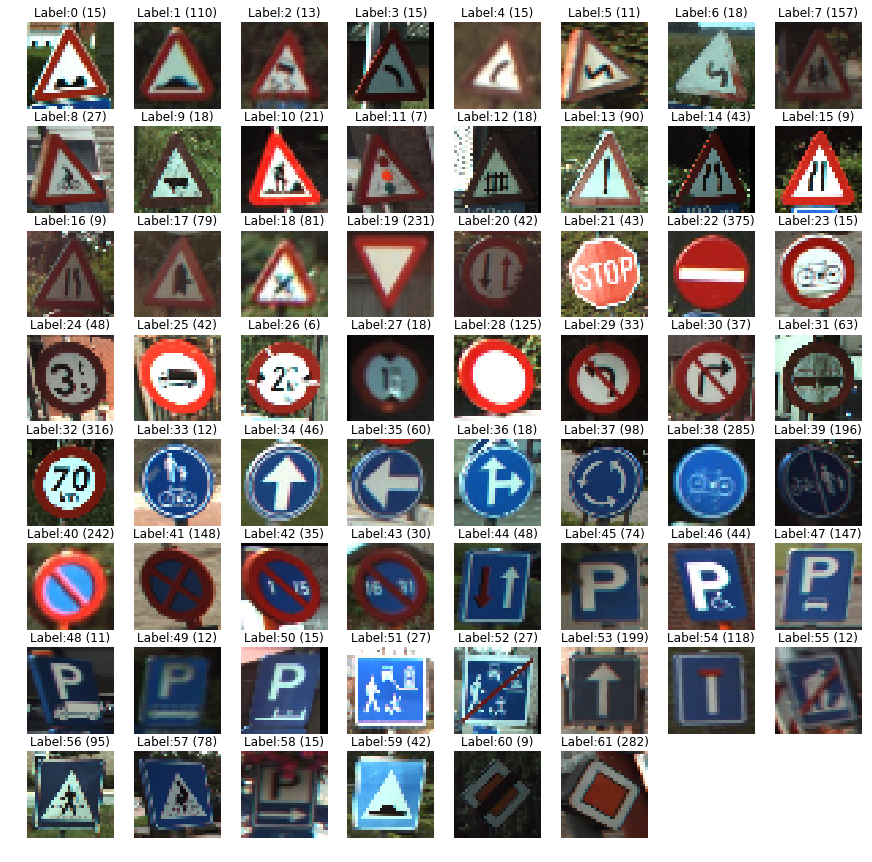

In [16]:
####显示裁剪后的结果
display_imgs_and_labels(images32,labs)  

虽然图像被缩小至32x32但是对人来说仍然可以识别。

In [18]:
for _ in images32[:5]:
    print("裁剪后图像尺寸{0},图像像素的最大值{1}，最小值{2}".format(_.shape,_.max(),_.min()))

裁剪后图像尺寸(32, 32, 3),图像像素的最大值1.0，最小值0.007391237745097998
裁剪后图像尺寸(32, 32, 3),图像像素的最大值1.0，最小值0.003576899509805663
裁剪后图像尺寸(32, 32, 3),图像像素的最大值1.0，最小值0.0015567555147030507
裁剪后图像尺寸(32, 32, 3),图像像素的最大值0.9692670036764703，最小值0.05677466299019637
裁剪后图像尺寸(32, 32, 3),图像像素的最大值0.98952205882353，最小值0.026654411764708015


## 把变量images和labs转为numpy数组，然后将图像灰度化

(4575, 32, 32, 3) (4575,)


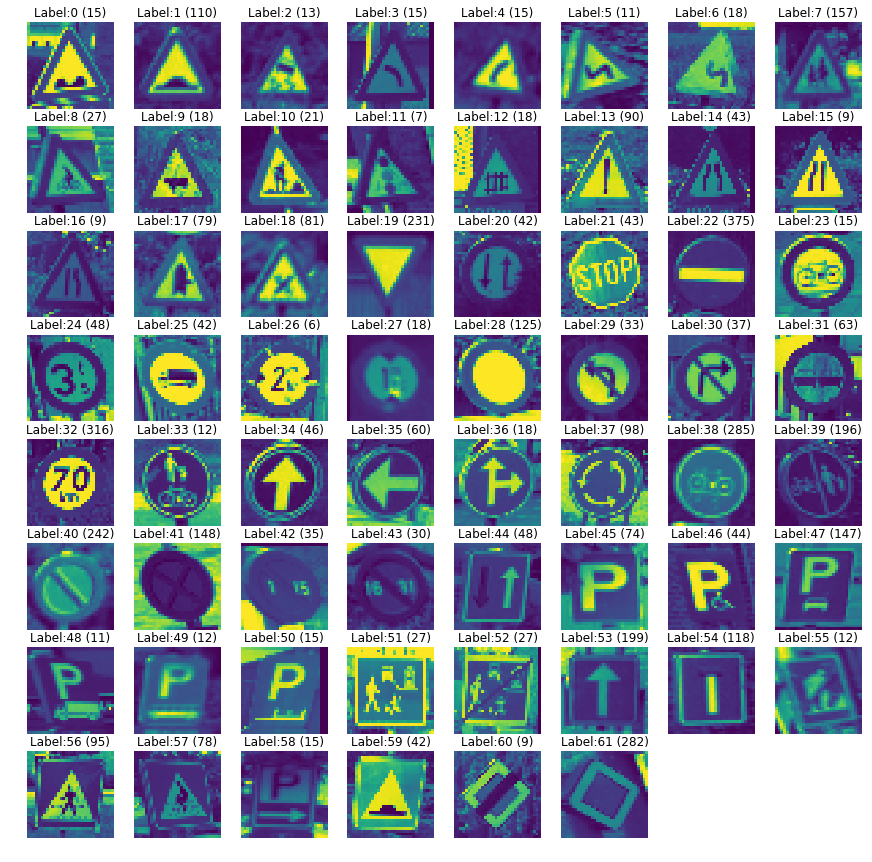

(4575, 32, 32)

In [20]:
images_a=np.array(images32)
labs_a=np.array(labs)
print(images_a.shape,labs_a.shape)
images_gray=color.rgb2gray(images_a)
display_imgs_and_labels(images_gray,labs) 
images_gray.shape

## 引入平移和旋转将数据集扩充为原来的5倍

In [21]:
?zip

In [22]:
from scipy import ndimage
?ndimage.rotate
#ndimage.rotate(input, angle, axes=(1, 0), reshape=False)

In [23]:
?ndimage.shift
#ndimage.shift(input, shift)

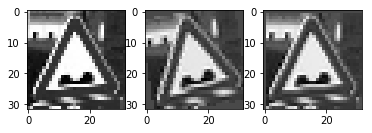

In [24]:
bg_value = np.median(images_gray[0])
I_r=ndimage.rotate(images_gray[0],10,reshape=False, cval=bg_value)
I_s=ndimage.shift(images_gray[0],0.2,cval=bg_value)
plt.subplot(1,3,1)
plt.imshow(images_gray[0],cmap='gray')

plt.subplot(1,3,2)
plt.imshow(I_r,cmap='gray')

plt.subplot(1,3,3)
plt.imshow(I_s,cmap='gray')

In [25]:
print("labels: ", labs_a.shape, "\nimages: ", images_gray.shape)

labels:  (4575,) 
images:  (4575, 32, 32)


In [26]:
def expend_training_data(images,labels):
    images_e=np.zeros([(images.shape[0])*5,images.shape[1],images.shape[2]])
    labels_e=np.zeros([(labels.shape[0])*5])
    itera=0
    for im,la in zip(images,labels):
        bg_value = np.median(im)
        for i in range(5):
            angle=np.random.randint(-10,10,1)
            I_r=ndimage.rotate(im,angle,reshape=False, cval=bg_value)
            shift=np.random.randint(-2,2,2)
            I_s=ndimage.shift(im,shift,cval=bg_value)
            images_e[itera]=I_s
            labels_e[itera]=la
            itera+=1
            
    return images_e,labels_e

In [27]:
#labels_2=labels[:,np.newaxis]
temp=labs_a[:,np.newaxis]
temp.shape

(4575, 1)

In [28]:
train_x,train_y=expend_training_data(images_gray,temp)

In [29]:
train_x.shape

(22875, 32, 32)

In [30]:
train_y.shape

(22875,)

In [31]:
####显示每个标签的第一张图像，并且累积每个标签内部图像的个数
def display_imgs_and_labels2(imgs,labs):
    plt.figure(figsize=(15,15))
    i=1
    labs=list(labs)
    for j in range(len(set(labs))):
        img=imgs[labs.index(j)]
        plt.subplot(8,8,i)
        plt.axis('off')
        plt.title("Label:{0} ({1})".format(j,labs.count(j)))
        plt.imshow(img,cmap='gray')
        i+=1
    plt.show()

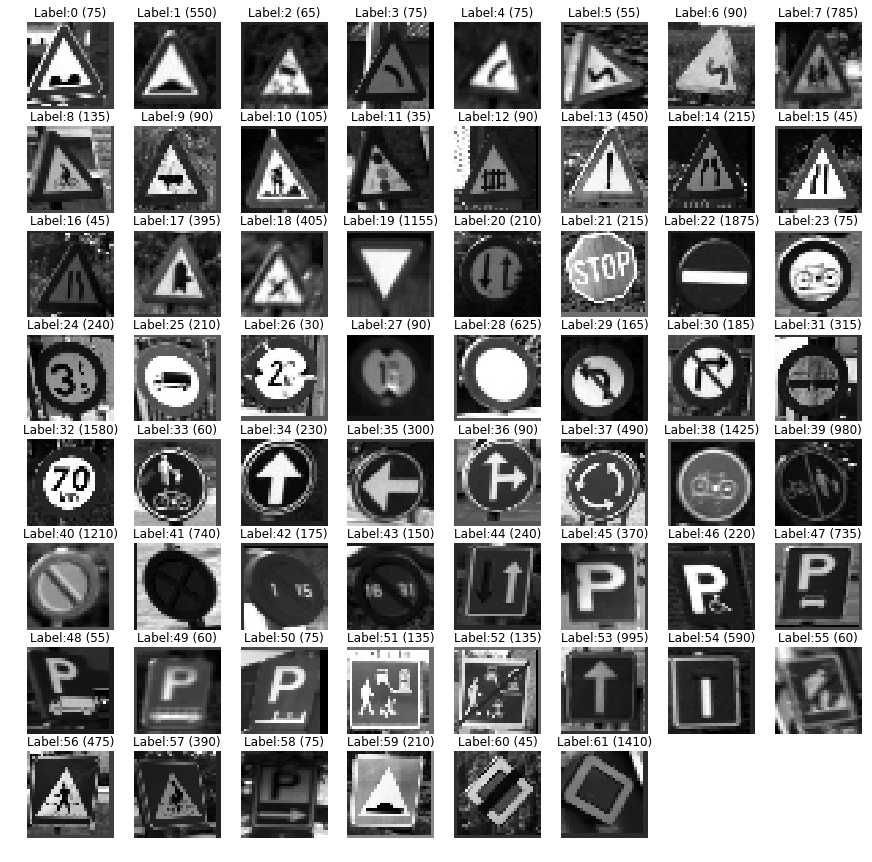

In [32]:
display_imgs_and_labels2(train_x,train_y)

### 将图像打乱使用sklearn utilities(utils)的shuffle

In [33]:
from sklearn.utils import shuffle
indx=np.arange(0,train_y.shape[0])
indx=shuffle(indx)
train_x=train_x[indx]
train_y=train_y[indx]

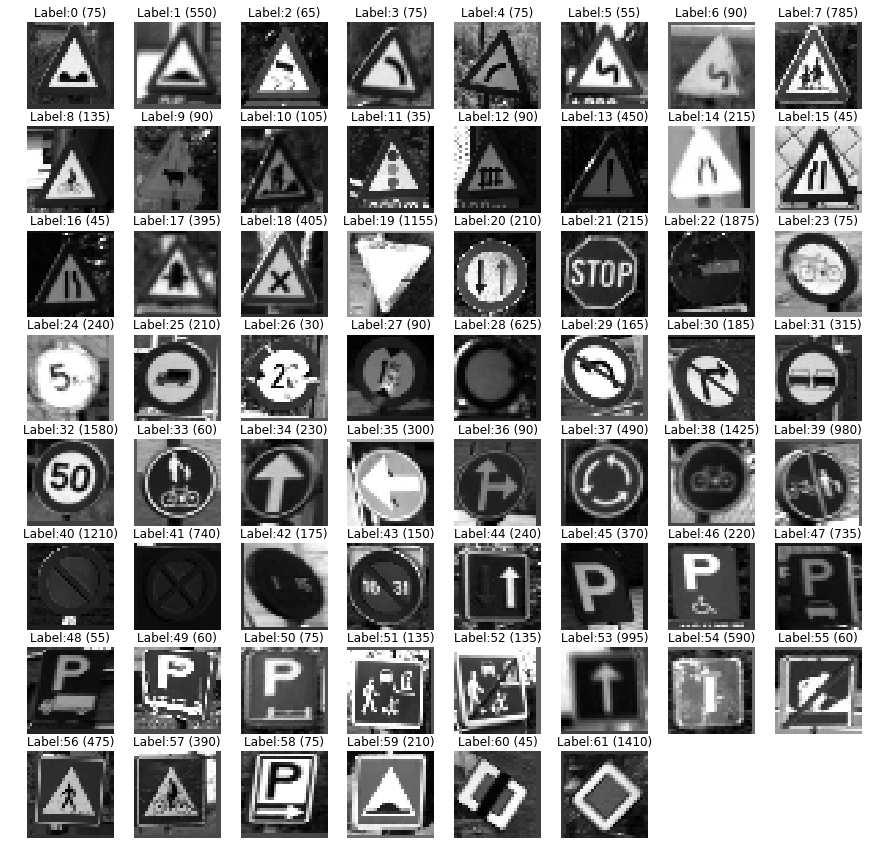

In [34]:
display_imgs_and_labels2(train_x,train_y)

## 原数据大小为22875，可以把20000作为训练集，2875作为验证集

In [35]:
import keras
from keras.utils import np_utils
train_X,val_X=train_x[:20000],train_x[20000:]
train_Y,val_Y=train_y[:20000],train_y[20000:] 
train_Y = keras.utils.to_categorical(train_Y, 62)
val_Y = keras.utils.to_categorical(val_Y, 62)
print(train_X.shape, train_Y.shape)

(20000, 32, 32) (20000, 62)


## 使用keras构建卷积神经网络模型

In [36]:
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

model=Sequential()
###layer 1
model.add(Convolution2D(filters=32,kernel_size=(3,3),input_shape=(32,32,1),strides=(1,1),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same'))

###layer 2
model.add(Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same'))

###layer 3
model.add(Convolution2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same'))

model.add(Flatten())

model.add(Dense(128))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(62,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
__________

In [37]:
train_X=np.reshape(train_X,(-1,32,32,1))###-1表示剩余维度
val_X=np.reshape(val_X,(-1,32,32,1))

model.compile(optimizer=Adam(),loss="categorical_crossentropy",metrics=['accuracy'])
history=model.fit(train_X,train_Y,epochs=20,batch_size=128,verbose=1,validation_data=(val_X,val_Y))
print(history.history.keys())
model.save('model.json')

Train on 20000 samples, validate on 2875 samples
Epoch 1/20
20000/20000 [==============================] - 61s 3ms/step - loss: 1.9276 - acc: 0.5250 - val_loss: 0.6767 - val_acc: 0.8077
Epoch 2/20
20000/20000 [==============================] - 57s 3ms/step - loss: 0.3870 - acc: 0.8852 - val_loss: 0.2198 - val_acc: 0.9357
Epoch 3/20
20000/20000 [==============================] - 57s 3ms/step - loss: 0.1435 - acc: 0.9559 - val_loss: 0.1324 - val_acc: 0.9628
Epoch 4/20
20000/20000 [==============================] - 56s 3ms/step - loss: 0.0845 - acc: 0.9764 - val_loss: 0.0733 - val_acc: 0.9784
Epoch 5/20
20000/20000 [==============================] - 57s 3ms/step - loss: 0.0400 - acc: 0.9883 - val_loss: 0.0472 - val_acc: 0.9812
Epoch 6/20
20000/20000 [==============================] - 57s 3ms/step - loss: 0.0282 - acc: 0.9918 - val_loss: 0.0418 - val_acc: 0.9889
Epoch 7/20
20000/20000 [==============================] - 57s 3ms/step - loss: 0.0360 - acc: 0.9914 - val_loss: 0.0586 - val_acc:

In [38]:
print(train_X.shape,train_Y.shape,val_X.shape,val_Y.shape)

(20000, 32, 32, 1) (20000, 62) (2875, 32, 32, 1) (2875, 62)


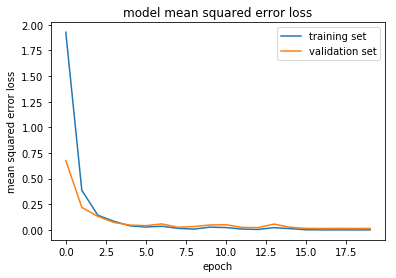

In [39]:
def plot_training(history):
    ### plot the training and validation loss for each epoch
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

plot_training(history=history)

## 查看模型在测试集上的准确率

## 测试集图像预处理：读取、尺度、rgb2gray

In [42]:
test_path='./traffic_sign_classifer/traffic_sign_classifer/data/Testing'

test_imgs,test_labs= load_data(test_path)
test_images32=[(skimage.transform.resize(item,(32,32))) for item in test_imgs]

test_images_a=np.array(test_images32)
test_labs_a=np.array(test_labs)
test_images_gray=color.rgb2gray(test_images_a)

e:\python\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
e:\python\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [50]:
test_x=np.reshape(test_images_gray,(-1,32,32,1))###-1表示剩余维度
test_y=np.reshape(test_labs_a,(-1,1))
test_y = keras.utils.to_categorical(test_y, 62)
evaluation=model.evaluate(test_x,test_y,batch_size=128,verbose=0)
print("prediction on test data\nloss:{0}  accuracy:{1}".format(evaluation[0],evaluation[1]))

prediction on test data
loss:0.49095749126096805  accuracy:0.9178571432355851


### 在测试集上的预测结果及显示

In [52]:
pred=model.predict(test_x)
pred=np.argmax(pred,1)
pred.shape

(2520,)

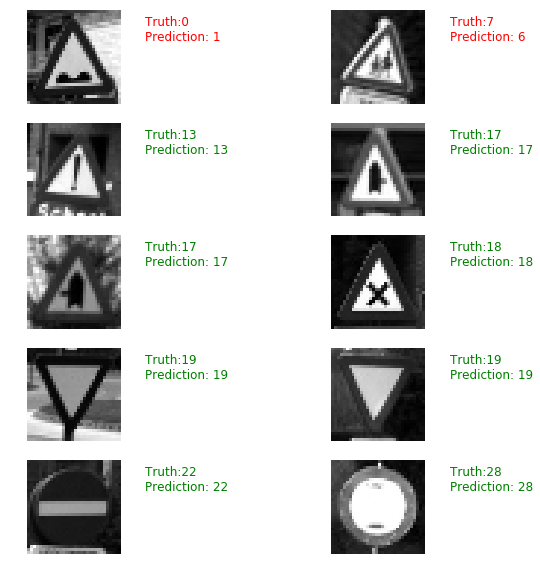

In [59]:
plt.figure(figsize=(10,10))
i=1
for _ in range(0,1000,100):
    truth=test_labs_a[_]
    prediction=pred[_]
    plt.subplot(5,2,i)
    i+=1
    plt.axis('off')
    if truth == prediction:
        color='green' 
    else:
        color='red'
    plt.text(40, 10, "Truth:{0}\nPrediction: {1}".format(truth, prediction),fontsize=12, color=color)
    plt.imshow(test_x.reshape(-1, 32, 32)[_], cmap='gray')